In [31]:
import pandas as pd
import math
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from itertools import combinations
%matplotlib inline

In [2]:
def filterDataset(data):
    invalidIndexes = []
    for row in data.itertuples():
        if '?' in row:
            invalidIndexes.append(row[0])
    new_data = data.drop(data.index[invalidIndexes])
    cols = list(new_data.columns)
    new_data[cols] = new_data[cols].astype('float32')
    return new_data

In [3]:
def train_and_test():
    data = pd.read_csv('processed.cleveland.data', names=['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num'], header=None)
    data = filterDataset(data)
    ## split data into train and test
    cols = list(data.columns)
    cols.remove('num')
    target = data['num'].copy()
    input_data = data[cols].copy()
    global targetTest
    dTrain, dTest, targetTrain, targetTest = train_test_split(input_data, target, test_size=0.20, stratify=target)
    train_index = dTrain.index
    scaler = preprocessing.StandardScaler().fit(dTrain)
    dTrain = scaler.transform(dTrain)
    cols = [i for i in range(dTrain.shape[1])]
    dTrain = pd.DataFrame(dTrain, index=train_index, columns=cols)
    classes = [0,1,2,3,4]
    votes = np.zeros((dTest.shape[0], len(classes)), dtype=np.int)
    clfs = []
    global clfs_score
    while len(classes) > 1:
        current_class = classes.pop(0)
        for c in classes:
            d = pd.concat([dTrain,targetTrain], axis=1, ignore_index=True)
            d = d.reset_index(drop=True)
            current_group = pd.concat([d[d[13]==current_class], d[d[13]==c]], axis=0, ignore_index=False)
            y = current_group[13].copy()
            cols = list(current_group.columns)
            cols.remove(13)
            x = current_group[cols].copy()

            #print('Training model for classes ', current_class, 'and ', c, '...')
            clf = SVC(kernel='linear', probability=True, class_weight='balanced', random_state=0).fit(x, y)
            clfs.append(clf)
    for clf in clfs:
        dTest = scaler.transform(dTest)
        cols = [i for i in range(dTest.shape[1])]
        dTest = pd.DataFrame(dTest, columns=cols)
        clf_pred = clf.predict(dTest)
        try:
            clfs_score[clfs.index(clf)] += clf.decision_function(dTest)
        except:
            clfs_score.append(clf.decision_function(dTest))
        for i in range(clf_pred.shape[0]):
            votes[np.int(dTest.iloc[[i]].index[0]), np.int(clf_pred[i])] += 1
    pred = []
    for i in range(votes.shape[0]):
        pred.append(np.argmax(votes[i,:]))
    
    cm = confusion_matrix(targetTest, pred, labels=[0,1,2,3,4])
    score = np.sum(np.diagonal(cm))/np.sum(cm)
    #print('score: ', score)
    np.savetxt("confusion_matrix_ava.csv", cm, delimiter=",")
    
    return score

In [40]:
targetTest = 0
scores = []
clfs_score = []
for i in tqdm(range(100)):
    score = train_and_test()
    scores.append(score)
    
scores = np.asarray(scores)
clfs_score = [i/100 for i in clfs_score]
print(scores.mean())
print(scores.std())

100%|██████████| 100/100 [00:26<00:00,  3.94it/s]     | 1/100 [00:00<00:27,  3.63it/s]

0.539333333333
0.0490759049274


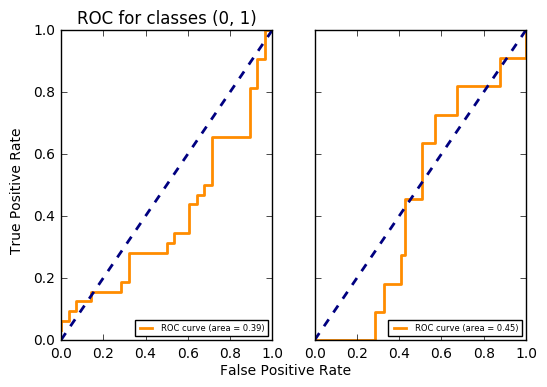

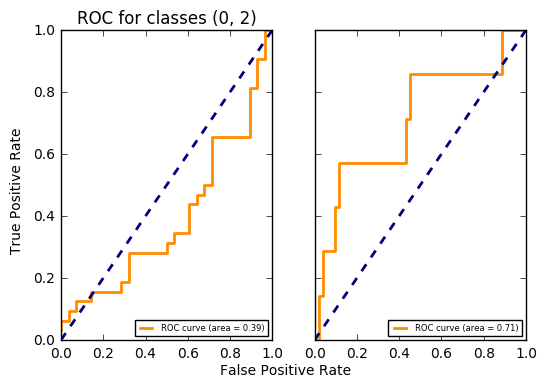

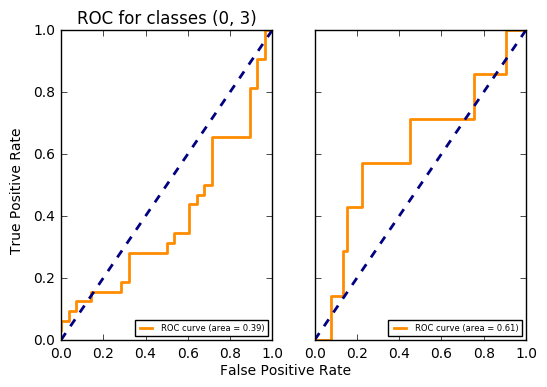

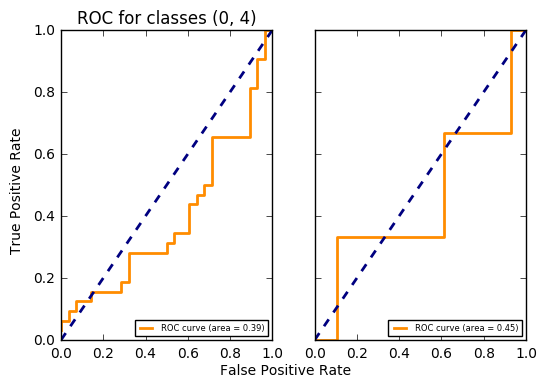

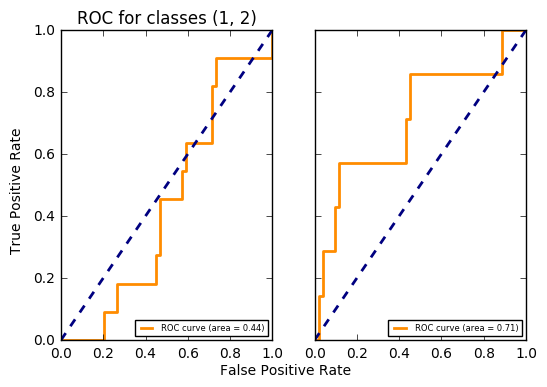

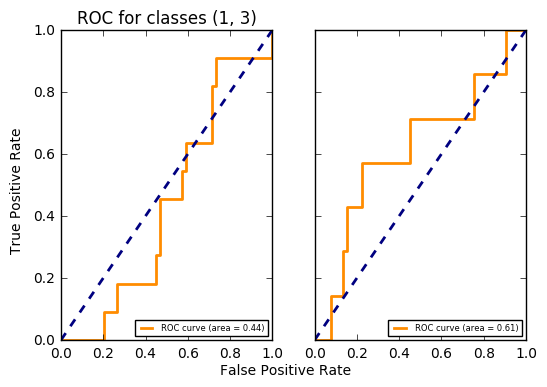

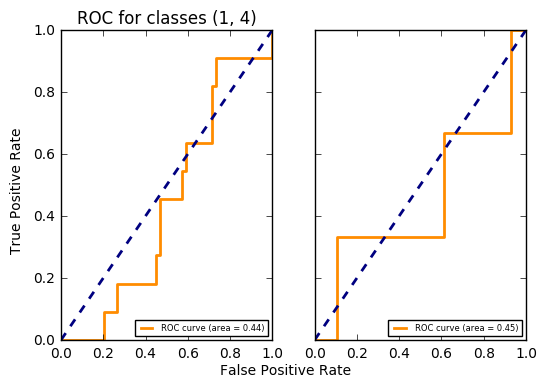

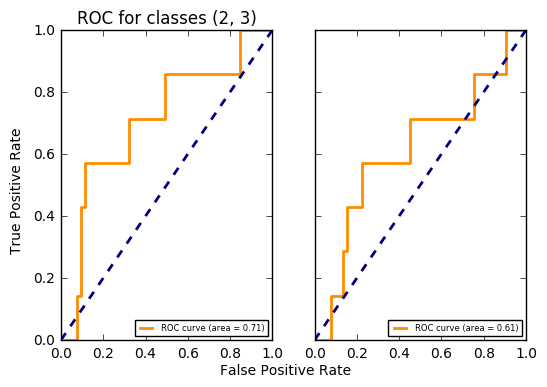

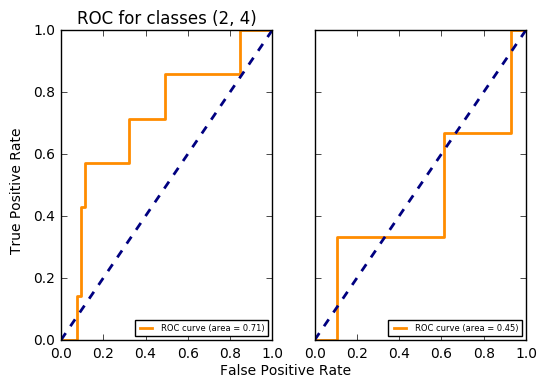

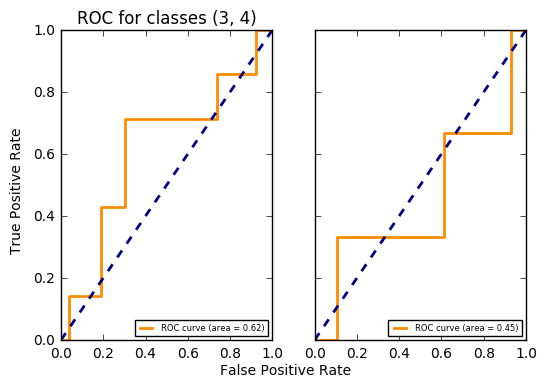

In [41]:
#Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
pairs = list(combinations([0,1,2,3,4], 2))
for i in range(len(clfs_score)):
    target_bin = label_binarize(targetTest, classes=[pairs[i][0], pairs[i][1]])
    fpr_ava = []
    tpr_ava = []
    auc_ava = []
    for j in range(target_bin.shape[1]):
        temp_fpr, temp_tpr, _ = roc_curve(target_bin[:,j], clfs_score[j])
        fpr_ava.append(temp_fpr)
        tpr_ava.append(temp_tpr)
        temp_roc_auc = auc(temp_fpr, temp_tpr)
        auc_ava.append(temp_roc_auc)
    fpr[i] = fpr_ava
    tpr[i] = tpr_ava
    roc_auc[i] = auc_ava
    
for i in range(len(clfs_score)):
    plt.figure()
    lw = 2
    f, ((ax1, ax2)) = plt.subplots(1, 2, sharex='col', sharey='row')
    ax1.plot(fpr[i][0], tpr[i][0], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i][0])
    ax1.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax1.set_title('ROC for classes ' + str(pairs[i]))
    ax2.plot(fpr[i][1], tpr[i][1], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i][1])
    ax2.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

    ax1.legend(loc="lower right", prop={'size':6})
    ax2.legend(loc="lower right", prop={'size':6})
    
    f.text(0.5, 0.04, 'False Positive Rate', ha='center')
    f.text(0.04, 0.5, 'True Positive Rate', va='center', rotation='vertical')
    plt.show()